In [11]:
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

from sklearn.utils import resample
import albumentations as A
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
print(tf.__version__)


2.16.2


In [12]:
# -isic_2019
#   -ISIC_2019_Training_Input
#       -ISIC_2019_Training_GroundTruth.csv
#       -ISIC_2019_Training_Input
#           -images
#   -ISIC_2019_Test_Input
#       -ISIC_2019_Test_GroundTruth.csv
#       -ISIC_2019_Test_Input
#           -images

training_path = "../isic_2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
testing_path = "../isic_2019/ISIC_2019_Test_Input/ISIC_2019_Test_Input"

training_labels_path = "../isic_2019/ISIC_2019_Training_Input/ISIC_2019_Training_GroundTruth.csv"
testing_labels_path = "../isic_2019/ISIC_2019_Test_Input/ISIC_2019_Test_GroundTruth.csv"

training_labels = pd.read_csv(training_labels_path)
print("Found training labels")
testing_labels = pd.read_csv(testing_labels_path)
print("Found testing labels")

def load_data(path):
    data = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            data.append(filename)
    return data

training_data = load_data(training_path)
print("Training data: ", len(training_data))
testing_data = load_data(testing_path)
print("Testing data: ", len(testing_data))

print("Training labels: ", len(training_labels))
print("Testing labels: ", len(testing_labels))


Found training labels
Found testing labels
Training data:  25331
Testing data:  8238
Training labels:  25331
Testing labels:  8238


In [13]:
# Verify extracted data


df = training_labels
print("Training labels preview:")
print(df.head())


# Peek of MEL column and NON-MEL values
melanoma_count = df[df["MEL"] == 1].shape[0]
non_melanoma_count = df[df["MEL"] == 0].shape[0]

# Printing the counts
print(f"Melanoma images: {melanoma_count}")
print(f"Non-Melanoma images: {non_melanoma_count}")

# Get overall class distribution
print(df["MEL"].value_counts(normalize=True) * 100)  # Shows % distribution


Training labels preview:
          image  MEL
0  ISIC_0000000  0.0
1  ISIC_0000001  0.0
2  ISIC_0000002  1.0
3  ISIC_0000003  0.0
4  ISIC_0000004  1.0
Melanoma images: 4522
Non-Melanoma images: 20809
MEL
0.0    82.148356
1.0    17.851644
Name: proportion, dtype: float64


In [14]:
'''FILTERING'''
# Hair removal
def remove_hair(img):
    #Black hat filter
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(7,17))
    blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(img,mask,7,cv2.INPAINT_TELEA)
    # plt.imshow(dst)
    # plt.show
    return dst
    
# Gray scale
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
# Noise reduction
def reduce_noise(image):
    bilateral = cv2.bilateralFilter(image, 9, 75, 75)
    median = cv2.medianBlur(bilateral, 5)
    return median
    
# Contrast enhancement
def enhance_contrast(image):
    enhanced_img = (cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))).apply(image)
    return enhanced_img

# Resizing
def resize_img(img, size=(224, 224)):
    resized_img = cv2.resize(img, size)
    return resized_img

# Other filters (need to debug)

# Edge detection
def segment_lesion(image):
        
    #https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html 
    # look at Otsu binarization; very nice
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

def enhance_borders(image):

    # https://docs.opencv.org/4.x/d2/d2c/tutorial_sobel_derivatives.html
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient = np.sqrt(sobelx**2 + sobely**2)
    
    gradient = np.uint8(gradient * 255 / gradient.max())
    return gradient


In [15]:
'''PREPROCESSING'''
import shutil
def preprocessing(image):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = convert_to_grayscale(image)
    hair_remove = remove_hair(gray)
    noise_reduced = reduce_noise(hair_remove)
    
    contrast = enhance_contrast(noise_reduced)

    # Very wonky things happen depending on specific images when trying to get specific borders
    #mask = segment_lesion(image)   
    # borders = enhance_borders(noise_reduced)
    #final = cv2.bitwise_and(contrast, contrast, mask=mask)

    resized = cv2.resize(contrast, (224,224))
    return resized

def preprocess_all_images(image_list, output_dir):
    if not os.path.exists(output_dir):
        print("Creating output directory")
        os.makedirs(output_dir)
    elif os.path.exists(output_dir):
        print("Output directory already exists, deleting")
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)
    
    i = 0
    for image_name in range(len(image_list)): # <------------------------------ Change for full dataset len(image_list)
        i += 1
        if i % 1000 == 0:
            print(f"Preprocessing image {i}/{len(image_list)}")
        image_name = image_list[image_name]
        image_path = os.path.join(training_path, image_name)
        preprocessed_image = preprocessing(image_path)
        output_path = os.path.join(output_dir, image_name)
        cv2.imwrite(output_path, preprocessed_image)

preprocess_all_images(training_data, "../old_preprocessed_images")

Output directory already exists, deleting
Preprocessing image 1000/25331
Preprocessing image 2000/25331
Preprocessing image 3000/25331
Preprocessing image 4000/25331
Preprocessing image 5000/25331
Preprocessing image 6000/25331
Preprocessing image 7000/25331
Preprocessing image 8000/25331
Preprocessing image 9000/25331
Preprocessing image 10000/25331
Preprocessing image 11000/25331
Preprocessing image 12000/25331
Preprocessing image 13000/25331
Preprocessing image 14000/25331
Preprocessing image 15000/25331
Preprocessing image 16000/25331
Preprocessing image 17000/25331
Preprocessing image 18000/25331
Preprocessing image 19000/25331
Preprocessing image 20000/25331
Preprocessing image 21000/25331
Preprocessing image 22000/25331
Preprocessing image 23000/25331
Preprocessing image 24000/25331
Preprocessing image 25000/25331


In [16]:
'''UPDATING LABELS'''

def update_labels(labels_path):
    df = pd.read_csv(labels_path)
    df = df[['image', 'MEL']] # Drop other columns
    return df


df_train_labels_updated = update_labels(training_labels_path)

In [17]:
'''DATA AUGMENTATION'''

'''UNDERSAMPLING'''
# Simple random undersampling to achieve desired balance
# random_state HH 88

def undersample_data(df, majority_split, new_labels_path):
    majority = df[df["MEL"] == 0]
    minority = df[df["MEL"] == 1]

    # Calculate size
    # major_count = majority.shape[0]
    minor_count = minority.shape[0]
    size = int(minor_count // (1 - majority_split)) - minor_count

    majority_undersampled = resample(majority,
                                    replace=False,
                                    n_samples=size,
                                    random_state=88)
    
    df_undersampled = pd.concat([majority_undersampled, minority])
    df_ordered = df_undersampled.sort_values(by="image").reset_index(drop=True)

    # print(df_ordered[df_ordered["MEL"] == 0].shape[0])
    # print(df_ordered[df_ordered["MEL"] == 1].shape[0])
         

    df_ordered.to_csv(new_labels_path, index=False)
    #print(len(df_ordered))

majority_split = 0.5 # XX% majority (Non-Melanoma), XX% minority (Melanoma)
undersample_data(df_train_labels_updated, majority_split, "../old_preprocessed_images/ISIC_2019_Training_GroundTruth_preprocessed.csv")


In [ ]:
def load_process_images(image_path):
    image_path += ".jpg"
    img = load_img(image_path)
    img_array = img_to_array(img)

    img_array = img_array / 255.0
    return img_array


def get_all_data(all_images, labels, path):
    images = []
    all_labels = []

    for img, label in zip(all_images, labels):
        img_path = os.path.join(path, img).replace("\\", "/")
        img_pixels = load_process_images(img_path)

        images.append(img_pixels)
        all_labels.append(label)
    
    return np.array(images), np.array(all_labels)



# old model 81%; new model 95% - terrible loss
def build_model():

    # random bs
    model = models.Sequential([
        
       layers.Conv2D(32, (3, 3), activation='relu',
               padding='same', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # sigmoid here
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model




In [19]:
# File paths
labels_path = "../old_preprocessed_images/ISIC_2019_Training_GroundTruth_preprocessed.csv"
images_path = "../old_preprocessed_images"

In [20]:
''' 
Create 80 - 20 train test (validation set) split

stratify - Ensures class distribution is similar in both sets based on the labels

'''
df = pd.read_csv(labels_path)
image_names = df['image'].values # X - images
image_labels = df['MEL'].values # y - labels

X_train_names, X_test_names, y_train, y_test = train_test_split(image_names, image_labels, 
                                                    test_size=0.2, random_state=88, stratify=image_labels)

# print("Train set size: ", len(X_train))
# print("Test set size: ", len(X_test))

X_train, y_train = get_all_data(X_train_names, y_train, images_path)

X_testing, y_testing = get_all_data(X_test_names, y_test, images_path)

model = build_model()


C:\Users\anony\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting training...
Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.6128 - auc: 0.6490 - loss: 0.7852 - precision: 0.6135 - recall: 0.5926 - val_accuracy: 0.4903 - val_auc: 0.4839 - val_loss: 0.7915 - val_precision: 0.4903 - val_recall: 0.5011 - learning_rate: 0.0010
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step - accuracy: 0.6388 - auc: 0.6899 - loss: 0.6826 - precision: 0.6370 - recall: 0.6351 - val_accuracy: 0.5102 - val_auc: 0.7040 - val_loss: 0.9986 - val_precision: 1.0000 - val_recall: 0.0199 - learning_rate: 0.0010
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.6705 - auc: 0.7376 - loss: 0.6095 - precision: 0.6830 - recall: 0.6358 - val_accuracy: 0.6622 - val_auc: 0.7540 - val_loss: 0.6160 - val_precision: 0.7856 - val_recall: 0.4458 - learning_rate: 0.0010
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.6949 - auc: 0.7668 - loss: 0.5786 - precision: 0.7026 - recall: 0.6713 - val_accuracy: 0.6866 - val_auc: 0.7658

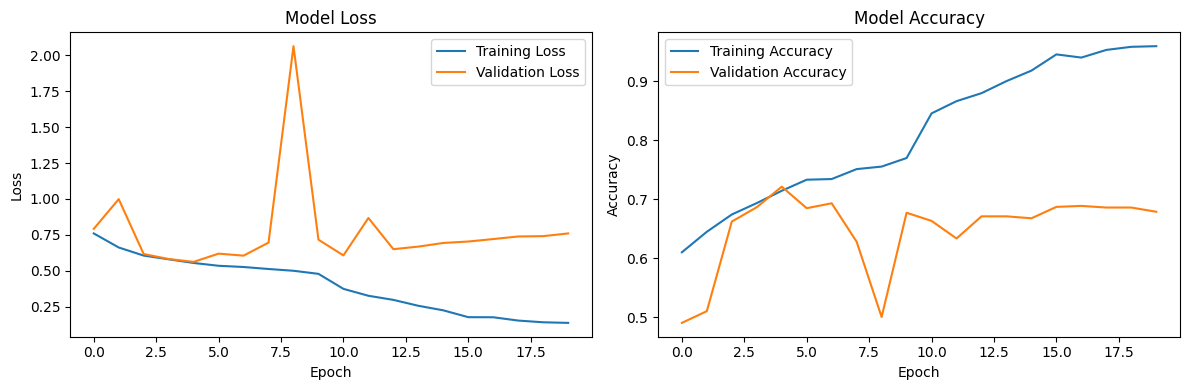

In [21]:
#CONSTANTS

BATCH_SIZE = 32
EPOCHS = 50


model = build_model()


total = len(y_train)
pos_weight = (total / (2 * np.sum(y_train)))
neg_weight = (total / (2 * (total - np.sum(y_train))))
class_imbal = {0: neg_weight, 1: pos_weight}

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 
                tf.keras.metrics.AUC(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()]
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Train the model
print("Starting training...")
modeling = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_testing, y_testing),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_imbal,
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(modeling.history['loss'], label='Training Loss')
plt.plot(modeling.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(modeling.history['accuracy'], label='Training Accuracy')
plt.plot(modeling.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

In [23]:
model.save('../melanoma_undersample_model.keras')